<a href="https://colab.research.google.com/github/danplotkin/image_captioning_with_scst/blob/main/ImageCaptioner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Architecture

The architecture for this image captioner is based on the research paper titled [CPTR: Full Transformer Network for Image Captioning
](https://arxiv.org/pdf/2101.10804) via Liu et al. (2021). Below is an image from the original paper showing the architecture:

<img src='https://media.licdn.com/dms/image/C4D12AQGA3qFX3peTbw/article-cover_image-shrink_720_1280/0/1648387317335?e=2147483647&v=beta&t=4VOpEV8ptM4B4Q0UTZJUWqv4QFQvIuCubBoQLzJazds' width='800'>



# Import Libraries

In [1]:
import os
from google.colab import userdata, drive
drive.mount('/content/drive')
from tqdm.notebook import tqdm
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from typing import Union, Optional, Literal
import string
import gc
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.distributions.categorical import Categorical
import torchvision
from torchvision import transforms
from transformers import (
    AutoTokenizer,
    ViTImageProcessor,
    ViTModel,
    get_cosine_schedule_with_warmup,
    PreTrainedTokenizer
)

from nltk.translate.meteor_score import single_meteor_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

from sklearn.model_selection import train_test_split

torch.manual_seed(42)

Mounted at /content/drive


In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Define Configs

Below we will define the configurations.

In [3]:
# ViT Configs
VIT_PREPROCESSOR = ViTImageProcessor.from_pretrained('google/vit-base-patch16-384')
VIT_BACKBONE = ViTModel.from_pretrained('google/vit-base-patch16-384', add_pooling_layer=False)

# Tokenizer Config
TOKENIZER = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Transformer Configs
MAX_SEQ_LEN = 80
BATCH_SIZE = 40
EMBED_DIM = 768
N_HEADS = 12
DENSE_NEURONS = EMBED_DIM * 2
NUM_LAYERS = 4

# Supervised TRAINING CONFIGS
NUM_EPOCHS = 15
MAX_LR = 1e-4

# Beam Search Configs
BEAM_SIZE = 3

# SCST Configs
SCST_LR = 5e-6
SCST_EPOCHS = 2
SCST_BATCH_SIZE = 12

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Get Data

In [4]:
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

In [5]:
!kaggle datasets download -d adityajn105/flickr8k
!mkdir flickr8k
!unzip -qq flickr8k.zip -d flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
100% 1.03G/1.04G [00:50<00:00, 21.8MB/s]
100% 1.04G/1.04G [00:50<00:00, 21.9MB/s]


# Load in Data

In [6]:
IMAGE_PATH = 'flickr8k/Images'
CAPTIONS_PATH = 'flickr8k/captions.txt'

In [7]:
def preprocess_captions(caption: str) -> pd.DataFrame:
    """
    Function to preprocess captions.
    """
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    caption = " ".join(word.lower() for word in caption.split())
    caption = caption.strip()
    return caption


def create_mappings(captions_path: str, images_path: str) -> dict[str, list[str]]:
    """
    Function to create mappings from images to captions.
    """
    # Load in text doc
    with open(captions_path, mode='r') as f:

        next(f)
        doc = f.read()

    # create dictionary
    mapping = {}
    images_to_delete = []
    for line in tqdm(doc.split('\n')):
        split = line.split(',')
        if len(split) >= 2:
            # split image with description
            image, description = split[0], ",".join(split[1:])
            description = preprocess_captions(description)
            image = os.path.join(IMAGE_PATH, image)

            # remove images with small captions
            if len(description.split()) < 5:
                images_to_delete.append(image)

            # add images into dictionary
            if image not in mapping:
                mapping[image] = []
            mapping[image].append(description)

            # delete images that had short captions
            for img in images_to_delete:
                if img in mapping:
                    del mapping[img]

    return mapping


mappings = create_mappings(CAPTIONS_PATH, IMAGE_PATH)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [8]:
len(mappings)

7467

# Preprocess Data

## Create Train-Validation-Test Sets

In [9]:
def train_val_test_mapping_split(
        mapping: dict[str, list[str]],
        train_size: float = 0.8,
        valid_size: float = 0.2
    ) -> tuple[list[tuple[str, str]], list[tuple[str, str]], list[tuple[str, str]]]:

    image_paths = list(mapping.keys())

    # Set seed and shuffle
    np.random.seed(42)
    np.random.shuffle(image_paths)

    split = int(len(image_paths) * train_size)

    train_keys = image_paths[:split]
    test_keys = image_paths[split:]

    # Sample validation from train set
    train_keys, valid_keys = train_test_split(train_keys, test_size=valid_size, shuffle=True, random_state=42)

    # Create lists of tuples for each split
    train_list = [(key, caption) for key in train_keys for caption in mapping[key]]
    valid_list = [(key, caption) for key in valid_keys for caption in mapping[key]]
    test_list = [(key, caption) for key in test_keys for caption in mapping[key]]

    # Shuffle lists
    np.random.shuffle(train_list)
    np.random.shuffle(valid_list)
    np.random.shuffle(test_list)

    return train_list, valid_list, test_list

In [10]:
train_list, valid_list, test_list = train_val_test_mapping_split(mappings)
print(f'Number of training examples: {len(train_list)}')
print(f'Number of validation examples: {len(valid_list)}')
print(f'Number of test examples: {len(test_list)}')

Number of training examples: 23890
Number of validation examples: 5975
Number of test examples: 7470


## Define ViT Transforms

In [11]:
def apply_vit_transforms(image: Image.Image, return_tensors: str = 'pt'):
    return VIT_PREPROCESSOR(image, return_tensors=return_tensors)['pixel_values'].squeeze(0)


transformations = {
    'train': transforms.Compose([
        apply_vit_transforms,
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.RandomRotation(degrees=10),
        transforms.RandomApply(transforms=[transforms.ColorJitter(brightness=.3, hue=.1)], p=0.3),
    ]),
    'test': apply_vit_transforms,
    'inverse_normalize': transforms.Normalize(
        mean=-torch.tensor(VIT_PREPROCESSOR.image_mean)/torch.tensor(VIT_PREPROCESSOR.image_std),
        std=1/torch.tensor(VIT_PREPROCESSOR.image_std)
    )
}

## Build Custom Dataset

In [12]:
class Flickr8kDataset(Dataset):
    def __init__(self, dataset: list[str, str], transform: any = None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx: int):
        image_path, captions = self.dataset[idx]

        # Preprocess image
        image = Image.open(image_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Preprocess text
        captions = TOKENIZER.encode(captions, return_tensors='pt').flatten()
        input_text = captions[:-1]
        target_text = captions[1:]

        # Pad to max length
        input_text = F.pad(input_text, (0, MAX_SEQ_LEN - len(input_text)), value=0)
        target_text = F.pad(target_text, (0, MAX_SEQ_LEN - len(target_text)), value=0)
        return (image, input_text), target_text

In [13]:
train_dataset = Flickr8kDataset(train_list, transform=transformations['train'])
valid_dataset = Flickr8kDataset(valid_list, transform=transformations['test'])
test_dataset = Flickr8kDataset(test_list, transform=transformations['test'])

We will print some images with the input and target captions to validate our preprocessing

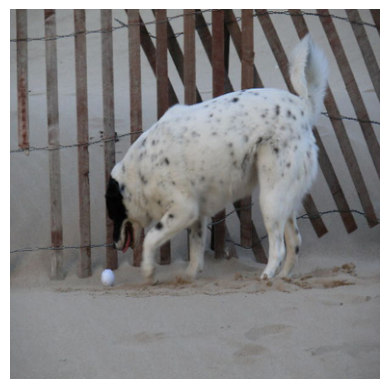

Input Text: [CLS] a white dog with black spots looks at a golf ball in the sand
Target Text: a white dog with black spots looks at a golf ball in the sand [SEP]


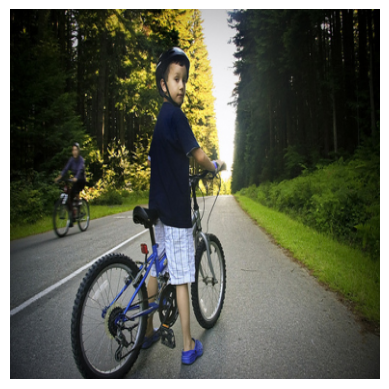

Input Text: [CLS] a boy stopped on his bike on a bike trail as a woman passes by
Target Text: a boy stopped on his bike on a bike trail as a woman passes by [SEP]


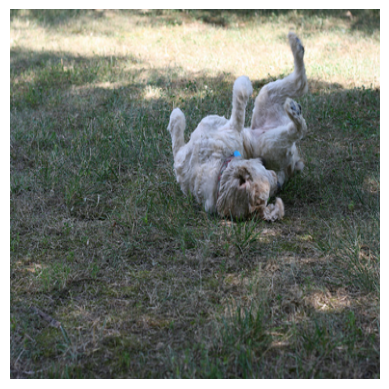

Input Text: [CLS] a tan dog rolls in the grass
Target Text: a tan dog rolls in the grass [SEP]


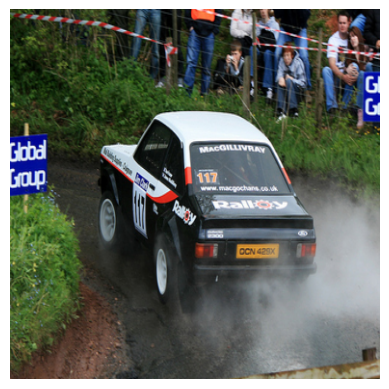

Input Text: [CLS] the race car is speeding up the hill
Target Text: the race car is speeding up the hill [SEP]


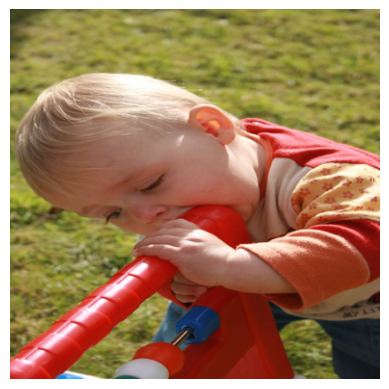

Input Text: [CLS] a baby is trying to eat a large red plastic toy outdoors
Target Text: a baby is trying to eat a large red plastic toy outdoors [SEP]


In [14]:
# Print image with captions
i = 0
for (image, input_text), target_text in valid_dataset:
    image = transformations['inverse_normalize'](image)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    print(f'Input Text: {" ".join([token for token in TOKENIZER.decode(input_text.tolist()).split() if token != "[PAD]"])}')
    print(f'Target Text: {" ".join([token for token in TOKENIZER.decode(target_text.tolist()).split() if token != "[PAD]"])}')
    i +=1
    if i == 5:
        break

## Batch into DataLoaders

In [15]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
# Validate shapes
print('Train shapes:')
for (image, input_text), target_text in train_loader:
    print(image.shape)
    print(input_text.shape)
    print(target_text.shape)
    break

print('\nVal shapes:')
for (image, input_text), target_text in valid_loader:
    print(image.shape)
    print(input_text.shape)
    print(target_text.shape)
    break


print('\nTest shapes:')
for (image, input_text), target_text in test_loader:
    print(image.shape)
    print(input_text.shape)
    print(target_text.shape)
    break

Train shapes:
torch.Size([40, 3, 384, 384])
torch.Size([40, 80])
torch.Size([40, 80])

Val shapes:
torch.Size([40, 3, 384, 384])
torch.Size([40, 80])
torch.Size([40, 80])

Test shapes:
torch.Size([40, 3, 384, 384])
torch.Size([40, 80])
torch.Size([40, 80])


# Design CPTR Layers

## ViT Backbone

As the architecture says, we will be using a pretrained ViT as our image encoder. This will allow our encoder to process our images as 1D 16x16 patches.

In [17]:
class ViTBackbone(nn.Module):
    def __init__(self, freeze_params: bool = True):
        super(ViTBackbone, self).__init__()
        self.backbone = VIT_BACKBONE
        if freeze_params:
            for param in self.backbone.parameters():
                param.requires_grad = False
            print('Frozen ViT backbone')

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x).last_hidden_state

## Positional Embedding Layer

We will create a custom module for our decoder embeddings. Along with token embeddings via `nn.Embeddings`, we need to add positional encodings as well to understand the sequential positioning of each token. To do this, we will create a `SinusodialPositionalEncodings` layer that implements the sinusodial positional encodings formula from the original [Attention is All You Need](https://arxiv.org/pdf/1706.03762) paper:

$$ PE(pos, 2i) = sin\left(\frac{pos}{10000^{2i/d}}\right) $$

$$ PE(pos, 2i+1) = cos\left(\frac{pos}{10000^{2i/d}}\right) $$

where:
- $PE$ is the positional encoding
- $pos$ is the position
- $i$ is the dimension
- $d$ is the total number of dimensions

These encodings will be added to our token embeddings from outputs of our `nn.Embeddings` forward pass.

In [18]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding_dim = embedding_dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.embedding(x) * math.sqrt(self.embedding_dim)


class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_seq_length: int, dropout: float = 0.1):
        super(SinusoidalPositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(x + self.pe[:, :x.size(1)])


class PositionalEmbedding(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, max_len: int, dropout: float = 0.1):
        super(PositionalEmbedding, self).__init__()
        self.embedding = TokenEmbedding(vocab_size, embedding_dim)
        self.positional_encoding = SinusoidalPositionalEncoding(embedding_dim, max_len, dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        x = self.positional_encoding(x)
        return x

## Decoder

In [19]:
decoder_layer = nn.TransformerDecoderLayer(
    d_model=EMBED_DIM,
    nhead=N_HEADS,
    dim_feedforward=DENSE_NEURONS,
    batch_first=True
)
decoder = nn.TransformerDecoder(decoder_layer, num_layers=NUM_LAYERS)

# Define Model

We will now define the our final CPTR model based on the architecture we are implementing from.

In [20]:
class CPTR(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, max_len: int):
        super(CPTR, self).__init__()
        self.backbone = ViTBackbone()
        self.positional_embedding = PositionalEmbedding(vocab_size, embedding_dim, max_len)
        self.decoder = decoder
        self.fc = nn.Linear(embedding_dim, vocab_size)
        self.max_length = max_len

    def forward(self, inputs: tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        """
        Forward call for teacher forcing. Not meant for evaluation.
        Args:
            inputs: (image, input_text)
        """
        image, input_text = inputs

        # Compute masks
        tgt_key_padding_mask = self.compute_padding_mask(input_text)
        tgt_mask = self.compute_causal_mask(input_text)

        # Encode image
        image = self.backbone(image)

        # Embed text and compute padding mask
        input_text = self.positional_embedding(input_text)

        # Decode text
        output = self.decoder(
            input_text,
            image,
            tgt_key_padding_mask=tgt_key_padding_mask,
            tgt_mask=tgt_mask,
            tgt_is_causal=True
        )

        # Fully connected head
        output = self.fc(output)
        return output

    def predict_next_token(
            self,
            tokens: torch.Tensor,
            image_embeddings: torch.Tensor
        ) -> torch.Tensor:
        """
        Predict next token given tokens and image embeddings.
        Args:
            tokens: tokens
            image_embeddings: image embeddings
        """
        positional_embedding = self.positional_embedding(tokens)
        output = self.decoder(
            positional_embedding,
            image_embeddings,
            tgt_key_padding_mask=self.compute_padding_mask(tokens),
            tgt_mask=self.compute_causal_mask(tokens),
            tgt_is_causal=True
        )
        preds = self.fc(output)
        preds = preds[:, -1, :]
        return preds

    def compute_padding_mask(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute padding mask.
        Args:
            x: tokens
        """
        return x.eq(0)

    def compute_causal_mask(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute causal mask.
        Args:
            x: tokens
        """
        seq_len = x.size(1)
        mask = torch.triu(torch.ones((seq_len, seq_len)), diagonal=1).bool()
        return mask.to(x.device)

## Create Learning Rate Schedule and Model Params

In [21]:
model = CPTR(
    vocab_size=TOKENIZER.vocab_size,
    embedding_dim=EMBED_DIM,
    max_len=MAX_SEQ_LEN
)

model = model.to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=MAX_LR)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Learning rate scheduler
num_training_steps = len(train_loader) * NUM_EPOCHS
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_training_steps * 0.1,
    num_training_steps=num_training_steps
)

Frozen ViT backbone


# Train

## Define Metrics

In [22]:
def masked_accuracy(output: torch.Tensor, target: torch.Tensor) -> float:
    mask = target.ne(0)
    output = output.argmax(-1).masked_select(mask)
    target = target.masked_select(mask)
    return (output == target).float().mean()

## Define Early Stopping Callback

In [23]:
class EarlyStopping:
    def __init__(self, patience=2, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
        self.best_epoch = 0

    def __call__(self, model, val_loss, epoch):
        if self.best_loss == None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
            self.best_epoch = epoch
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model.load_state_dict(model.state_dict())
            self.best_epoch = epoch
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model.state_dict())
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

    def __str__(self):
        return self.status

## Define Trainer

In [24]:
class Trainer:
    def __init__(self, model, optimizer, scheduler, criterion, device, output_path, **early_stopping_kwargs):
        """
        Trainer for CPTR model.
        Args:
            model: model
            optimizer: optimizer
            scheduler: scheduler
            criterion: criterion
            device: device
            output_path: path to save model
            early_stopping_kwargs: early stopping kwargs
        """
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.scheduler = scheduler
        self.output_path = output_path
        self.history = {
            'train_losses': [],
            'valid_losses': [],
            'train_accuracies': [],
            'valid_accuracies': []
        }
        self.early_stopping = EarlyStopping(**early_stopping_kwargs)

    def train(self, train_loader, valid_loader, num_epochs, save_model):
        """
        Train model.
        Args:
            train_loader: train loader
            valid_loader: valid loader
            num_epochs: number of epochs
            save_model: save model
        """
        for epoch in range(1, num_epochs + 1):
            print(f'Epoch {epoch}/{num_epochs}:')
            train_loss, train_acc = self._train_epoch(train_loader)
            valid_loss, valid_acc = self._valid_epoch(valid_loader)

            # Append history
            self.history['train_losses'].append(train_loss)
            self.history['valid_losses'].append(valid_loss)
            self.history['train_accuracies'].append(train_acc)
            self.history['valid_accuracies'].append(valid_acc)

            print()

            # Check early stopping
            if self.early_stopping(self.model, valid_loss, epoch):
                print(f"Validation loss has not improved for {self.early_stopping.patience} epochs. Early stopping...")
                print(f"Reverting back to weights for epoch {self.early_stopping.best_epoch}.")
                break

        # Save model
        model_dir = os.path.dirname(self.output_path)
        if save_model:
            try:
                if not os.path.exists(model_dir):
                    os.makedirs(model_dir)
                self.save_model(self.output_path)
                print(f'Saved model to {model_dir}')
            except Exception as e:
                print(f'Error saving model: {e}')

        return {
            'model': self.model,
            'history': self.history
        }

    @torch.no_grad()
    def evaluate(self, test_loader):
        """
        Evaluate model.
        Args:
            test_loader: test loader
        """
        self.model.eval()
        return self._valid_epoch(test_loader, loader_type='Test')

    def save_model(self, path):
        """
        Save model.
        Args:
            path: path to save model
        """
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        """
        Load model.
        Args:
            path: path to load model
        """
        self.model.load_state_dict(torch.load(path))

    def _train_epoch(self, train_loader):
        """
        Train epoch.
        Args:
            train_loader: train loader
        """
        self.model.train()
        running_loss = 0
        running_acc = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, items in pbar:
            self.optimizer.zero_grad()

            batch_num = i + 1
            (image, input_text), target_text = items

            image, input_text, target_text = image.to(self.device), input_text.to(self.device), target_text.to(self.device)
            output = self.model((image, input_text))

            loss = self.criterion(output.view(-1, output.shape[-1]), target_text.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            # Update learning rate
            self.scheduler.step()

            running_acc += masked_accuracy(output, target_text).item()
            running_loss += loss.item()

            train_loss = running_loss / batch_num
            train_acc = running_acc / batch_num
            pbar.set_description(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

        return train_loss, train_acc

    @torch.no_grad()
    def _valid_epoch(self, valid_loader, loader_type="Valid"):
        """
        Valid epoch.
        Args:
            valid_loader: valid loader
        """
        self.model.eval()
        running_loss = 0
        running_acc = 0
        pbar = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for i, items in pbar:
            batch_num = i + 1
            (image, input_text), target_text = items
            image, input_text, target_text = image.to(self.device), input_text.to(self.device), target_text.to(self.device)
            output = self.model((image, input_text))
            loss = self.criterion(output.view(-1, output.shape[-1]), target_text.view(-1))
            running_acc += masked_accuracy(output, target_text).item()
            running_loss += loss.item()

            valid_loss = running_loss / batch_num
            valid_acc = running_acc / batch_num
            pbar.set_description(f'{loader_type} Loss: {valid_loss:.4f}, {loader_type} Acc: {valid_acc:.4f}')

        return valid_loss, valid_acc

## Train Model with Custom Trainer

In [25]:
# Define trainer
model_path = '/content/drive/MyDrive/Models/CPTR_PyTorch/cptr.pt'
trainer = Trainer(model, optimizer, scheduler, criterion, DEVICE, model_path, patience=1)

In [ ]:
training_dict = trainer.train(
    train_loader,
    valid_loader,
    NUM_EPOCHS,
    save_model=True
)

Epoch 1/15:


  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]


Epoch 2/15:


  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]


Epoch 3/15:


  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]


Epoch 4/15:


  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]


Epoch 5/15:


  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]


Epoch 6/15:


  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]


Epoch 7/15:


  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]


Epoch 8/15:


  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]


Epoch 9/15:


  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]


Epoch 10/15:


  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]


Validation loss has not improved for 1 epochs. Early stopping...
Reverting back to weights for epoch 9.
Saved model to /content/drive/MyDrive/Models/CPTR_PyTorch


# Evaluate Initial Model Training

## View Masked Loss and Accuracy on Test Loader

In [ ]:
_ = trainer.evaluate(test_loader)

  0%|          | 0/187 [00:00<?, ?it/s]

In [ ]:
_ = trainer.evaluate(valid_loader)

  0%|          | 0/150 [00:00<?, ?it/s]

## Plot Loss and Accuracy during Training

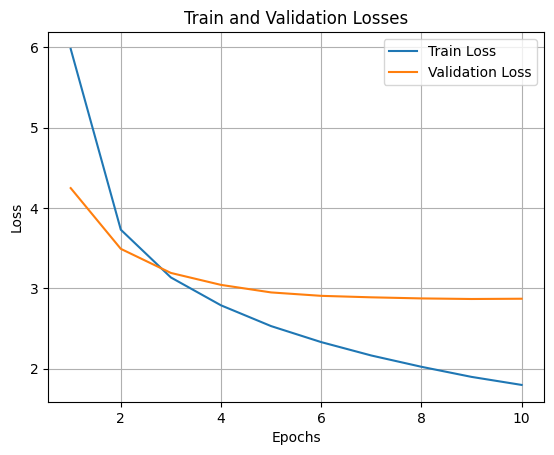

In [ ]:
# Define the train and validation losses
train_losses = training_dict['history']['train_losses']
val_losses = training_dict['history']['valid_losses']

# Define the epochs
epochs = list(range(1, len(train_losses) + 1))

# Plot the train and validation losses
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

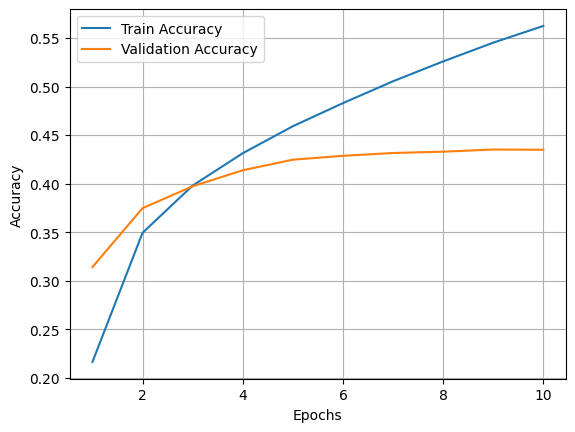

In [ ]:
# Training accuracies
train_accuracies = training_dict['history']['train_accuracies']

# Validation accuracies
val_accuracies = training_dict['history']['valid_accuracies']

# Epochs
epochs = list(range(1, len(train_accuracies) + 1))

plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Free Memory

In [26]:
del model, optimizer, scheduler, criterion, trainer, train_loader, valid_loader, test_loader
gc.collect()
torch.cuda.empty_cache()

# Finetune with Self-Critical Sequence Training (SCST)

## Create Dataloaders with Smaller Batch Sizes

We do this to prevent cuda out of memory errors.

In [27]:
scst_train_loader = DataLoader(
    train_dataset,
    batch_size=SCST_BATCH_SIZE,
    shuffle=True
)

scst_valid_loader = DataLoader(
    valid_dataset,
    batch_size=SCST_BATCH_SIZE,
    shuffle=False
)

scst_test_loader = DataLoader(
    test_dataset,
    batch_size=SCST_BATCH_SIZE,
    shuffle=False
)

## Load in Cached Weights

In [28]:
trained_model = CPTR(
    vocab_size=TOKENIZER.vocab_size,
    embedding_dim=EMBED_DIM,
    max_len=MAX_SEQ_LEN
)

trained_model.load_state_dict(torch.load(model_path))
trained_model = trained_model.to(DEVICE)

Frozen ViT backbone


## Define Reward Function (METEOR)

In [29]:
class MeteorScore:
    def __init__(self, tokenizer: PreTrainedTokenizer):
        """
        Meteor score function.
        Args:
            tokenizer: tokenizer
        """
        self.tokenizer = tokenizer

    def __call__(self, predictions: list[list[int]], references: list[list[int]], reduction: Literal[None, "sum", "mean"], **kwargs) -> Union[float, list[float]]:
        """
        Compute meteor score.
        Args:
            predictions: predictions
            references: references
            reduction: reduction mode
        Returns:
            meteor score
        """
        predictions = self.tokenizer.batch_decode(predictions, skip_special_tokens=True)
        references = self.tokenizer.batch_decode(references, skip_special_tokens=True)
        scores = []
        for pred, ref in zip(predictions, references):
            pred_tokens = pred.split()
            ref_tokens = ref.split()
            score = single_meteor_score(ref_tokens, pred_tokens, **kwargs)
            scores.append(score)

        if reduction == "sum":
            return sum(scores)
        elif reduction == "mean":
            return np.mean(scores)
        elif not reduction:
            return scores
        else:
            raise ValueError("Invalid reduction mode.")

## Define Sampling and Inference Time Algorithms

In [30]:
class ImageCaptionerInferencer:
    def __init__(self, model: CPTR, tokenizer: PreTrainedTokenizer):
        """
        Decoder methods for CPTR model.
        Args:
            model: model
            tokenizer: tokenizer
        """
        self.model = model
        self.tokenizer = tokenizer

    def beam_search(self, image: torch.Tensor, max_length: int, beam_size: int) -> list[int]:
        """
        Beam search for text generation. Only accepts single image as input.
        Args:
            model: model
            image: image
            max_length: maximum length of the generated text
            tokenizer: tokenizer
            beam_size: beam size
        """
        assert image.dim() == 3, "Image must be a shaped as (channels, height, width)"
        image = image.unsqueeze(0)
        image_embeddings = self.model.backbone(image)
        initial = torch.tensor([[self.tokenizer.cls_token_id]], dtype=torch.long, device=image.device)
        sequences = [[initial, 0]]  # [tokens, log_prob]
        for _ in range(max_length):
            all_candidates = []
            for seq, score in sequences:
                if seq[0][-1] == self.tokenizer.sep_token_id:
                    all_candidates.append((seq, score))
                    continue
                next_token_logits = self.model.predict_next_token(seq, image_embeddings)
                next_token_log_probs = F.log_softmax(next_token_logits, dim=-1)
                topk_log_probs, topk_indices = next_token_log_probs.topk(beam_size)
                for i in range(beam_size):
                    candidate_seq = torch.cat([seq, topk_indices[:, i].unsqueeze(0)], dim=1)
                    candidate_score = score + topk_log_probs[0, i].item()
                    all_candidates.append((candidate_seq, candidate_score))

            # Apply length normalization to the scores
            ordered = sorted(all_candidates, key=lambda tup: tup[1] / (len(tup[0][0])), reverse=True)
            sequences = ordered[:beam_size]
            if all(seq[0][-1] == self.tokenizer.sep_token_id for seq, _ in sequences):
                break
        return sequences[0][0].squeeze().tolist()

    def sample(self, images: torch.Tensor, max_length: int, return_log_probs: bool = True) -> Union[tuple[list[list[int]], torch.Tensor], list[list[int]]]:
        """
        Sample text from the model in batch mode.
        Args:
            images: batch of images (batch_size, channels, height, width)
            max_length: maximum length of the generated text
            return_log_probs: whether to return log_probs
        Returns:
            tokens: tokens (batch_size, seq_len)
            log_probs: log_probs (batch_size, seq_len)
        """
        assert images.dim() == 4, "Images must be a shaped as (batch_size, channels, height, width)"
        batch_size = images.size(0)
        image_embeddings = self.model.backbone(images)
        tokens = torch.full((batch_size, 1), self.tokenizer.cls_token_id, device=DEVICE, dtype=torch.long)
        log_probs_list = []  # Initialize an empty list to store log_probs
        done_mask = torch.zeros(batch_size, dtype=torch.bool, device=DEVICE)

        for _ in range(max_length):
            logits = self.model.predict_next_token(tokens, image_embeddings).squeeze()
            m = Categorical(logits=logits)
            token = m.sample()

            # Append log_prob or zero if sequence is done
            log_prob = m.log_prob(token)
            log_prob = log_prob.masked_fill(done_mask, 0.0)
            log_probs_list.append(log_prob)  # Append log_prob to the list

            # Update done mask
            done_mask = done_mask | (token == self.tokenizer.sep_token_id)

            # Avoid modifying finished sequences
            token = token.masked_fill(done_mask, self.tokenizer.sep_token_id)

            tokens = torch.cat((tokens, token.unsqueeze(1)), dim=1)

            # If all sequences are done, break
            if done_mask.all():
                break

        log_probs = torch.stack(log_probs_list, dim=1).squeeze(-1)  # Stack the list into a tensor after the loop
        tokens = tokens.squeeze().tolist()
        if return_log_probs:
            return tokens, log_probs
        else:
            return tokens

    def greedy_search(self, images: torch.Tensor, max_length: int) -> list[list[int]]:
        """
        Greedy sample text from the model in batch mode.
        Args:
            images: batch of images (batch_size, channels, height, width)
            max_length: maximum length of the generated text
        """
        assert images.dim() == 4, "Images must be a shaped as (batch_size, channels, height, width)"
        batch_size = images.size(0)
        image_embeddings = self.model.backbone(images)
        tokens = torch.full((batch_size, 1), self.tokenizer.cls_token_id, device=DEVICE, dtype=torch.long)
        done_mask = torch.zeros(batch_size, dtype=torch.bool, device=DEVICE)

        for _ in range(max_length):
            logits = self.model.predict_next_token(tokens, image_embeddings)
            token = torch.argmax(logits, dim=-1)

            # Update done mask
            done_mask = done_mask | (token == self.tokenizer.sep_token_id)

            # Avoid modifying finished sequences
            token = token.masked_fill(done_mask, self.tokenizer.sep_token_id)

            tokens = torch.cat((tokens, token.unsqueeze(1)), dim=1)

            # If all sequences are done, break
            if done_mask.all():
                break

        tokens = tokens.squeeze().tolist()
        return tokens

## Define SCST Advantage and Loss Functions

In [31]:
def calculate_advantage(sampled_reward: torch.Tensor, baseline_reward: torch.Tensor) -> torch.Tensor:
    """
    Calculate SCST advantage for CPTR model.
    Args:
        sampled_reward: sampled reward
        baseline_reward: baseline reward
    """
    advantage = sampled_reward - baseline_reward
    return advantage


def reinforce_loss(advantage: torch.Tensor, log_probs: torch.Tensor) -> torch.Tensor:
    """
    Reinforce update for CPTR model.
    Args:
        advantage: advantage (batch_size,)
        log_probs: zero-padded log probabilites (batch_size, seq_len)
    """
    assert len(advantage) == len(log_probs), "Batch size mismatch"

    # Calculate masked loss
    advantage = advantage.unsqueeze(-1)
    sum_log_probs = torch.sum(log_probs, dim=-1)
    loss = -torch.mean(sum_log_probs * advantage)
    return loss

## Create Policy Tracker

This class will help monitor our SCST process and track which epoch has provided the maximum validation reward.

In [32]:
class PolicyTracker:
    def __init__(self, model: CPTR):
        """
        Policy tracker for SCST.
        Args:
            model: model
        """
        self.model = model
        self.best_model = copy.deepcopy(model)
        self.best_reward = -float('inf')
        self.best_epoch = 0
        self.num_updates = 0

    def __call__(self, reward: float, epoch: int):
        """
        Update policy tracker.
        Args:
            reward: reward
            epoch: epoch
        """
        self.num_updates += 1
        if reward > self.best_reward:
            self.best_reward = reward
            self.best_epoch = epoch
            self.best_model.load_state_dict(self.model.state_dict())

    def restore_best_weights(self):
        """
        Restore best weights.
        """
        self.model.load_state_dict(self.best_model.state_dict())

## Create SCST Trainer

In [33]:
class SCSTTrainer:
    def __init__(self, captioner, optimizer, device, max_seq_len, tokenizer, scheduler, output_path):
        self.model = captioner.model
        self.optimizer = optimizer
        self.device = device
        self.scheduler = scheduler
        self.scaler = GradScaler()
        self.captioner = captioner
        self.max_seq_len = max_seq_len
        self.tokenizer = tokenizer
        self.meteor_score = MeteorScore(tokenizer)
        self.history = {'val_meteor': []}
        self.output_path = output_path
        self.policy_tracker = PolicyTracker(self.model)

    def train(self, train_loader, valid_loader, num_epochs, save_model, restore_best=True):
        self.history['val_meteor'].clear()
        for epoch in range(1, num_epochs + 1):
            print(f'Epoch {epoch}/{num_epochs}:')

            # Print learning rate
            print(f'Epoch Learning Rate: {self.optimizer.param_groups[0]["lr"]}')

            # Train epoch
            self._train_epoch(train_loader)

            # Validate Epoch
            valid_score = self._valid_epoch(valid_loader)

            # Append history
            self.history['val_meteor'].append(valid_score)

            # Step epoch scheduler
            self.scheduler.step()

            # Update Policy Tracker
            self.policy_tracker(valid_score, epoch)
            print()

        # Restore best weights
        if restore_best:
            self.policy_tracker.restore_best_weights()
            print(f'Restored best weights at epoch {self.policy_tracker.best_epoch}')

        # Save model
        model_dir = os.path.dirname(self.output_path)
        if save_model:
            try:
                if not os.path.exists(model_dir):
                    os.makedirs(model_dir)
                self.save_model(self.output_path)
                print(f'Saved model to {model_dir}')
            except Exception as e:
                print(f'Error saving model: {e}')

        return {
            'model': self.model,
            'history': self.history
        }

    @torch.no_grad()
    def evaluate(self, test_loader):
        return self._valid_epoch(test_loader)

    def save_model(self, path):
        """
        Save model.
        Args:
            path: path to save model
        """
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        """
        Load model.
        Args:
            path: path to load model
        """
        self.model.load_state_dict(torch.load(path))

    def _train_epoch(self, train_loader):
        self.model.train()
        running_sampled_rewards = 0
        running_baseline_rewards = 0
        running_advantage = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, items in pbar:
            # Zero gradients
            self.optimizer.zero_grad()

            # Get batch number
            batch_num = i + 1

            # Get data from items
            (image, _), target_text = items
            image = image.to(self.device)
            target_text = target_text.tolist()

            # Forward passes
            with autocast():
                # Get baseline
                with torch.no_grad():
                    baseline_captions = self.captioner.greedy_search(image, self.max_seq_len)

                # Get sampled captions and log probs
                sampled_captions, log_probs = self.captioner.sample(image, self.max_seq_len)

            # Calculate rewards
            baseline_rewards = torch.tensor(self.meteor_score(baseline_captions, target_text, reduction=None), device=self.device)
            sampled_rewards = torch.tensor(self.meteor_score(sampled_captions, target_text, reduction=None), device=self.device)

            # Compute loss
            with autocast():
                advantage = calculate_advantage(sampled_rewards, baseline_rewards)
                loss = reinforce_loss(advantage, log_probs)

            # Backward pass + optimization
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            # Update running statistics
            running_advantage += advantage.mean().item()
            running_sampled_rewards += sampled_rewards.mean().item()
            running_baseline_rewards += baseline_rewards.mean().item()

            # Print progress
            train_adv = running_advantage / batch_num
            train_sampled_reward = running_sampled_rewards / batch_num
            train_baseline_reward = running_baseline_rewards / batch_num

            pbar.set_description(f'Train Adv: {train_adv:.4f}, Train Sampled Reward: {train_sampled_reward:.4f}, Train Baseline Reward: {train_baseline_reward:.4f}')

    @torch.no_grad()
    def _valid_epoch(self, valid_loader):
        self.model.eval()
        running_meteor = 0
        pbar = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for i, items in pbar:
            batch_num = i + 1
            (image, _), target_text = items
            image = image.to(self.device)
            target_text = target_text.tolist()
            actions = self.captioner.greedy_search(image, self.max_seq_len)
            meteor_score = self.meteor_score(actions, target_text, reduction='mean')
            running_meteor += meteor_score
            avg_meteor = running_meteor / batch_num
            pbar.set_description(f'Val METEOR: {avg_meteor:.4f}')

        return avg_meteor

## Define and Fine-Tune Model with SCST Trainer

### Initialize Trainer

In [34]:
# Define new optimizer and model path
scst_optimizer = optim.Adam(trained_model.parameters(), lr=SCST_LR)
SCST_MODEL_PATH = '/content/drive/MyDrive/Models/CPTR_PyTorch/cptr_scst.pt'

# Define lambda scheduler
scst_scheduler = optim.lr_scheduler.MultiplicativeLR(scst_optimizer, lambda epoch: 1.0 if epoch < 1 else 0.5)

# Initialize trainer
scst_trainer = SCSTTrainer(
    captioner=ImageCaptionerInferencer(trained_model, TOKENIZER),
    optimizer=scst_optimizer,
    device=DEVICE,
    max_seq_len=MAX_SEQ_LEN,
    tokenizer=TOKENIZER,
    scheduler=scst_scheduler,
    output_path=SCST_MODEL_PATH
)

### Get Baseline Test METEOR Score

In [35]:
score_before_scst = scst_trainer.evaluate(scst_test_loader)

  0%|          | 0/623 [00:00<?, ?it/s]

In [36]:
_ = scst_trainer.evaluate(scst_valid_loader)

  0%|          | 0/498 [00:00<?, ?it/s]

### Finetune

In [37]:
scst_training_dict = scst_trainer.train(
    scst_train_loader,
    scst_valid_loader,
    SCST_EPOCHS,
    save_model=True
)

Epoch 1/2:
Epoch Learning Rate: 5e-06


  0%|          | 0/1991 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]


Epoch 2/2:
Epoch Learning Rate: 2.5e-06


  0%|          | 0/1991 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]


Restored best weights at epoch 2
Saved model to /content/drive/MyDrive/Models/CPTR_PyTorch


### Get Finetuned Model Test METEOR

In [38]:
score_after_scst = scst_trainer.evaluate(scst_test_loader)

  0%|          | 0/623 [00:00<?, ?it/s]

# Generate Captions with Beam Search

## Load in Cached Weights

In [39]:
fine_tuned_model = CPTR(
    vocab_size=TOKENIZER.vocab_size,
    embedding_dim=EMBED_DIM,
    max_len=MAX_SEQ_LEN
)

fine_tuned_model.load_state_dict(torch.load(SCST_MODEL_PATH))
fine_tuned_model = fine_tuned_model.to(DEVICE)

Frozen ViT backbone


## Define Inferencer

In [40]:
scst_captioner = ImageCaptionerInferencer(fine_tuned_model, TOKENIZER)

## Define `generate_caption` Function that Uses Beam Search

In [41]:
@torch.no_grad()
def generate_caption(image: torch.Tensor, captioner: ImageCaptionerInferencer, tokenizer: PreTrainedTokenizer, max_length: int, beam_size: int) -> list[int]:
    """
    Generate caption for an image.
    Args:
        image: image
        captioner: captioner
        tokenizer: tokenizer
        max_length: maximum length of the generated text
        beam_size: beam size
    """
    plt.imshow(transformations['inverse_normalize'](image).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()
    with torch.no_grad():
        tokens = captioner.beam_search(image, max_length, beam_size)
    caption = tokenizer.decode(tokens, skip_special_tokens=True)
    print(f"Generated Caption: {caption}")
    return tokens


def get_random_test_image(test_dataset: Flickr8kDataset) -> torch.Tensor:
    """
    Get a random test image.
    Args:
        test_dataset: test dataset
    """
    idx = np.random.randint(0, len(test_dataset) - 1)
    (image, _), truth = test_dataset[idx]
    return image, truth

## Generate Captions

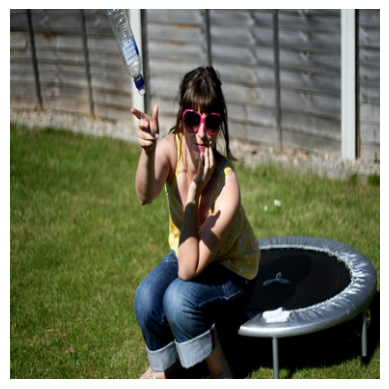

Generated Caption: a girl in a green shirt and glasses is sitting on a trampoline outside



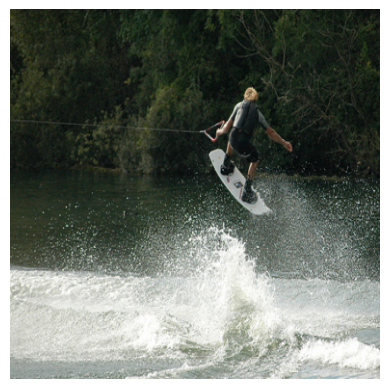

Generated Caption: a man in a wetsuit is surfing



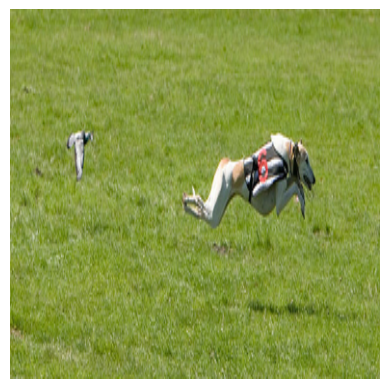

Generated Caption: a dog with a muzzle running in the grass



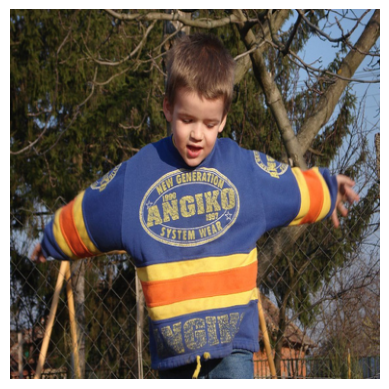

Generated Caption: a boy in a blue shirt and blue jeans is jumping on a trampoline in a park



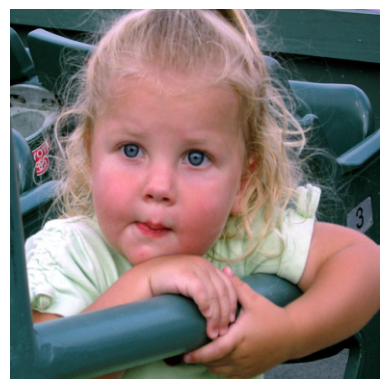

Generated Caption: a little girl is sitting on a park



In [42]:
meteor_score = MeteorScore(TOKENIZER)
for _ in range(5):
    image, truth = get_random_test_image(test_dataset)
    caption = generate_caption(image.to(DEVICE), scst_captioner, TOKENIZER, MAX_SEQ_LEN, BEAM_SIZE)
    print()